<a href="https://colab.research.google.com/github/prachi735/EVA4.0/blob/master/session6/EVA4_S6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, utils
import matplotlib.pyplot as plt
from pdb import set_trace as bp

# Transformations

In [0]:
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-5.0, 5.0), fill=(1,)),
                                       #transforms.RandomAffine((-5.0,5.0),fillcolor=1),
                                       #transforms.RandomPerspective(),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       ])
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       ])

# Load dataset

In [3]:
train = datasets.MNIST('./data', train=True, download=True,transform=train_transforms)
test = datasets.MNIST('./data', train=True, download=True,transform=test_transforms)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


# Dataloaders: Test/Train dataset

In [4]:
SEED = 3

# is cuda available
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

torch.manual_seed(SEED)

if cuda:
  torch.cuda.manual_seed(SEED)

# dataloader arguments
dataloader_args = dict(shuffle = True, batch_size = 128, num_workers = 4,pin_memory = True) if cuda else dict(shuffle = True, batch_size = 64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, ** dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Basic Model

In [0]:
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # input_size = 28 output_size = 26 receptive_field = 3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # input_size = 26 output_size = 24 receptive_field = 5
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # input_size = 24 output_size = 22 receptive_field = 7

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # input_size = 22 output_size = 11 receptive_field = 9
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        ) # input_size = 11 output_size = 11 receptive_field = 9

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        ) # input_size = 11 output_size = 9 receptive_field = 13
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        ) # input_size = 9 output_size = 7 receptive_field = 17
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        ) # input_size = 7 output_size = 5 receptive_field = 21
        # OUTPUT BLOCK
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(5, 5), padding=0, bias=False),
        ) # input_size = 5 output_size = 1  receptive_field = 29
        

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params

In [6]:
!pip install torchsummary
from torchsummary import summary

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1,28,28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           2,304
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9           [-1, 16, 22, 22]           2,304
             ReLU-10           [-1, 16, 22, 22]               0
      BatchNorm2d-11           [-1, 16, 22, 22]              32
          Dropout-12           [-1, 16, 22, 22]               0
        MaxPool2d-13           [-1, 16, 11, 11]               0
           Conv2d-14           [-1

#Training & Testing

In [0]:
from tqdm import tqdm


def train(model, device, train_loader, optimizer, epoch, l1_reg=False, l1_lambda=0):
  #bp()
  train_epoch_acc = []
  train_epoch_loss = []
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)

    if l1_reg:
       
        l1_crit = nn.L1Loss(size_average=False)
        reg_loss = 0
        for param in model.parameters():
            zero_tensor = torch.zeros(param.size()).to(device)
            reg_loss += l1_crit(param, zero_tensor)

        
        loss += l1_lambda * reg_loss

    # Backpropagation
    loss.backward()
    train_epoch_loss.append(loss.item())
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_epoch_acc.append(100*correct/processed)

  return train_epoch_acc, train_epoch_loss

def test(model, device, test_loader, 
         return_misclassified=False, 
         number_of_images_to_return=0, 
         return_worst_predictions=False):

    misclassified_images_list = []
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            pred_value = torch.max(output, dim=1).values

            
            match_tensor = pred.eq(target.view_as(pred))
            misclassified_images_in_batch = torch.where(match_tensor == True)
            for eachimage in misclassified_images_in_batch[0]:
               image_predlist = [data[eachimage], pred[eachimage].item(), pred_value[eachimage].item()]
               misclassified_images_list.append(image_predlist)
            correct += match_tensor.sum().item()

    test_loss /= len(test_loader.dataset)
    

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc = 100. * correct / len(test_loader.dataset)
    #bp()
    if return_misclassified:
      if not return_worst_predictions:
        return test_acc, test_loss, misclassified_images_list[:number_of_images_to_return]
      else:
        sorted_on_pred_value = sorted(misclassified_images_list, key = lambda x: x[2], reverse=True)
        return test_acc, test_loss, sorted_on_pred_value[:number_of_images_to_return]
    
    return test_acc, test_loss

# Train & Test model

In [8]:
train_acc_no_reg = []
train_losses_no_reg = []
test_acc_no_reg = []
test_losses_no_reg = []
model_no_reg =  Net().to(device)
optimizer = optim.SGD(model_no_reg.parameters(), lr=0.01, momentum=0.9)

EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train_epoch_acc_no_reg, train_epoch_losses_no_reg = train(model_no_reg, device, train_loader, optimizer, epoch)
    train_acc_no_reg.extend(train_epoch_acc_no_reg)
    train_losses_no_reg.extend(train_epoch_losses_no_reg)

    test_acc_no_reg_epoch, test_losses_no_reg_epoch = test(model_no_reg, device, test_loader)
    test_acc_no_reg.append(test_acc_no_reg_epoch)
    test_losses_no_reg.append(test_losses_no_reg_epoch)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.07537525147199631 Batch_id=468 Accuracy=93.00: 100%|██████████| 469/469 [00:14<00:00, 32.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0773, Accuracy: 58531/60000 (97.55%)

EPOCH: 1


Loss=0.05909997224807739 Batch_id=468 Accuracy=97.56: 100%|██████████| 469/469 [00:14<00:00, 32.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0502, Accuracy: 59049/60000 (98.42%)

EPOCH: 2


Loss=0.04082717001438141 Batch_id=468 Accuracy=98.01: 100%|██████████| 469/469 [00:14<00:00, 32.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0402, Accuracy: 59249/60000 (98.75%)

EPOCH: 3


Loss=0.0682196393609047 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:14<00:00, 32.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0386, Accuracy: 59264/60000 (98.77%)

EPOCH: 4


Loss=0.02496911585330963 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:14<00:00, 31.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0356, Accuracy: 59324/60000 (98.87%)

EPOCH: 5


Loss=0.04198862984776497 Batch_id=468 Accuracy=98.49: 100%|██████████| 469/469 [00:14<00:00, 31.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0285, Accuracy: 59431/60000 (99.05%)

EPOCH: 6


Loss=0.05104715749621391 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:14<00:00, 32.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0270, Accuracy: 59493/60000 (99.16%)

EPOCH: 7


Loss=0.10148269683122635 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:14<00:00, 31.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0290, Accuracy: 59457/60000 (99.09%)

EPOCH: 8


Loss=0.07683203369379044 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:14<00:00, 31.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0275, Accuracy: 59468/60000 (99.11%)

EPOCH: 9


Loss=0.013843531720340252 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:14<00:00, 32.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0244, Accuracy: 59564/60000 (99.27%)

EPOCH: 10


Loss=0.18864071369171143 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:14<00:00, 32.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 59565/60000 (99.28%)

EPOCH: 11


Loss=0.10629778355360031 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:14<00:00, 32.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0243, Accuracy: 59520/60000 (99.20%)

EPOCH: 12


Loss=0.09763053804636002 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:14<00:00, 31.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 59605/60000 (99.34%)

EPOCH: 13


Loss=0.02278020977973938 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:14<00:00, 32.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 59660/60000 (99.43%)

EPOCH: 14


Loss=0.04367266967892647 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:15<00:00, 31.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 59644/60000 (99.41%)

EPOCH: 15


Loss=0.016749436035752296 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:14<00:00, 31.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 59624/60000 (99.37%)

EPOCH: 16


Loss=0.01581587828695774 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:14<00:00, 39.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 59656/60000 (99.43%)

EPOCH: 17


Loss=0.18440155684947968 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:14<00:00, 31.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 59671/60000 (99.45%)

EPOCH: 18


Loss=0.060929205268621445 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:14<00:00, 31.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Accuracy: 59679/60000 (99.47%)

EPOCH: 19


Loss=0.04565292224287987 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:14<00:00, 31.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 59652/60000 (99.42%)

EPOCH: 20


Loss=0.05551479384303093 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:14<00:00, 31.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 59649/60000 (99.42%)

EPOCH: 21


Loss=0.04589730501174927 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:14<00:00, 31.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0166, Accuracy: 59685/60000 (99.47%)

EPOCH: 22


Loss=0.01707707904279232 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:14<00:00, 31.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 59677/60000 (99.46%)

EPOCH: 23


Loss=0.008632893674075603 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:14<00:00, 31.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0168, Accuracy: 59698/60000 (99.50%)

EPOCH: 24


Loss=0.0023284554481506348 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:14<00:00, 31.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0162, Accuracy: 59707/60000 (99.51%)

EPOCH: 25


Loss=0.009198576211929321 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:14<00:00, 31.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0152, Accuracy: 59727/60000 (99.55%)

EPOCH: 26


Loss=0.0034133244771510363 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:14<00:00, 31.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0145, Accuracy: 59740/60000 (99.57%)

EPOCH: 27


Loss=0.03850126266479492 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:14<00:00, 31.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0135, Accuracy: 59759/60000 (99.60%)

EPOCH: 28


Loss=0.007399340625852346 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:14<00:00, 38.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0143, Accuracy: 59740/60000 (99.57%)

EPOCH: 29


Loss=0.013379092328250408 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:14<00:00, 31.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0139, Accuracy: 59759/60000 (99.60%)

EPOCH: 30


Loss=0.005114187952131033 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:14<00:00, 37.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0150, Accuracy: 59734/60000 (99.56%)

EPOCH: 31


Loss=0.03449854627251625 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:14<00:00, 31.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0137, Accuracy: 59743/60000 (99.57%)

EPOCH: 32


Loss=0.0006675422191619873 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:14<00:00, 31.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0127, Accuracy: 59764/60000 (99.61%)

EPOCH: 33


Loss=0.024981915950775146 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:14<00:00, 31.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0131, Accuracy: 59760/60000 (99.60%)

EPOCH: 34


Loss=0.0036091904621571302 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:14<00:00, 32.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0147, Accuracy: 59723/60000 (99.54%)

EPOCH: 35


Loss=0.00173182284925133 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:14<00:00, 31.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0132, Accuracy: 59755/60000 (99.59%)

EPOCH: 36


Loss=0.03753046691417694 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:14<00:00, 31.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0118, Accuracy: 59792/60000 (99.65%)

EPOCH: 37


Loss=0.023638522252440453 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:14<00:00, 37.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0131, Accuracy: 59756/60000 (99.59%)

EPOCH: 38


Loss=0.02742135524749756 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:14<00:00, 31.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0125, Accuracy: 59775/60000 (99.62%)

EPOCH: 39


Loss=0.023222247138619423 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:15<00:00, 30.58it/s]



Test set: Average loss: 0.0111, Accuracy: 59792/60000 (99.65%)



In [9]:
train_acc_l1 = []
train_losses_l1 = []
test_acc_l1 = []
test_losses_l1 = []

model_l1 =  Net().to(device)
optimizer = optim.SGD(model_l1.parameters(), lr=0.01, momentum=0.9)
misclassified_dict_args = dict(return_misclassified = True, 
                          number_of_images_to_return=25,
                          return_worst_predictions=True)

EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train_epoch_acc_l1, train_epoch_losses_l1 = train(model_l1, device, train_loader, optimizer, epoch, l1_reg=True, l1_lambda=0.0005)
    train_acc_l1.extend(train_epoch_acc_l1)
    train_losses_l1.extend(train_epoch_losses_l1)

    if epoch == EPOCHS-1:
        test_acc_l1_epoch, test_losses_l1_epoch, misclassified_list_l1 = test(model_l1, device, test_loader, ** misclassified_dict_args)
    else:    
        test_acc_l1_epoch, test_losses_l1_epoch = test(model_l1, device, test_loader)

    test_acc_l1.append(test_acc_l1_epoch)
    test_losses_l1.append(test_losses_l1_epoch)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Loss=0.33243119716644287 Batch_id=468 Accuracy=92.45: 100%|██████████| 469/469 [00:18<00:00, 26.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0955, Accuracy: 58291/60000 (97.15%)

EPOCH: 1


Loss=0.24222518503665924 Batch_id=468 Accuracy=97.41: 100%|██████████| 469/469 [00:17<00:00, 26.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0584, Accuracy: 58923/60000 (98.20%)

EPOCH: 2


Loss=0.21173875033855438 Batch_id=468 Accuracy=97.68: 100%|██████████| 469/469 [00:17<00:00, 32.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0596, Accuracy: 58884/60000 (98.14%)

EPOCH: 3


Loss=0.19554801285266876 Batch_id=468 Accuracy=97.86: 100%|██████████| 469/469 [00:18<00:00, 26.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0449, Accuracy: 59183/60000 (98.64%)

EPOCH: 4


Loss=0.3026334047317505 Batch_id=468 Accuracy=97.93: 100%|██████████| 469/469 [00:17<00:00, 26.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0722, Accuracy: 58658/60000 (97.76%)

EPOCH: 5


Loss=0.20061977207660675 Batch_id=468 Accuracy=97.89: 100%|██████████| 469/469 [00:17<00:00, 34.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0514, Accuracy: 59008/60000 (98.35%)

EPOCH: 6


Loss=0.18135932087898254 Batch_id=468 Accuracy=97.97: 100%|██████████| 469/469 [00:17<00:00, 27.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0610, Accuracy: 58905/60000 (98.17%)

EPOCH: 7


Loss=0.2142905592918396 Batch_id=468 Accuracy=98.03: 100%|██████████| 469/469 [00:17<00:00, 27.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0472, Accuracy: 59143/60000 (98.57%)

EPOCH: 8


Loss=0.16441482305526733 Batch_id=468 Accuracy=98.04: 100%|██████████| 469/469 [00:16<00:00, 28.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0457, Accuracy: 59181/60000 (98.64%)

EPOCH: 9


Loss=0.18201641738414764 Batch_id=468 Accuracy=98.06: 100%|██████████| 469/469 [00:16<00:00, 27.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0424, Accuracy: 59238/60000 (98.73%)

EPOCH: 10


Loss=0.18939734995365143 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:16<00:00, 27.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0459, Accuracy: 59173/60000 (98.62%)

EPOCH: 11


Loss=0.20543867349624634 Batch_id=468 Accuracy=98.01: 100%|██████████| 469/469 [00:16<00:00, 27.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0558, Accuracy: 58952/60000 (98.25%)

EPOCH: 12


Loss=0.21568474173545837 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:16<00:00, 28.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0376, Accuracy: 59328/60000 (98.88%)

EPOCH: 13


Loss=0.13920627534389496 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:16<00:00, 32.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0427, Accuracy: 59206/60000 (98.68%)

EPOCH: 14


Loss=0.21358922123908997 Batch_id=468 Accuracy=98.09: 100%|██████████| 469/469 [00:16<00:00, 28.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0405, Accuracy: 59247/60000 (98.75%)

EPOCH: 15


Loss=0.2176564335823059 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:15<00:00, 29.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0572, Accuracy: 58961/60000 (98.27%)

EPOCH: 16


Loss=0.25004780292510986 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:16<00:00, 37.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0388, Accuracy: 59294/60000 (98.82%)

EPOCH: 17


Loss=0.17851585149765015 Batch_id=468 Accuracy=98.13: 100%|██████████| 469/469 [00:15<00:00, 29.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0440, Accuracy: 59181/60000 (98.64%)

EPOCH: 18


Loss=0.16522642970085144 Batch_id=468 Accuracy=98.16: 100%|██████████| 469/469 [00:15<00:00, 29.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0393, Accuracy: 59283/60000 (98.81%)

EPOCH: 19


Loss=0.16431404650211334 Batch_id=468 Accuracy=98.12: 100%|██████████| 469/469 [00:15<00:00, 29.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0400, Accuracy: 59260/60000 (98.77%)

EPOCH: 20


Loss=0.1727093607187271 Batch_id=468 Accuracy=98.13: 100%|██████████| 469/469 [00:15<00:00, 29.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0418, Accuracy: 59186/60000 (98.64%)

EPOCH: 21


Loss=0.16953188180923462 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:16<00:00, 29.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0373, Accuracy: 59305/60000 (98.84%)

EPOCH: 22


Loss=0.18898536264896393 Batch_id=468 Accuracy=98.12: 100%|██████████| 469/469 [00:15<00:00, 29.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0500, Accuracy: 59100/60000 (98.50%)

EPOCH: 23


Loss=0.1529020369052887 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:15<00:00, 29.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0459, Accuracy: 59115/60000 (98.53%)

EPOCH: 24


Loss=0.1536421775817871 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:16<00:00, 29.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0415, Accuracy: 59241/60000 (98.73%)

EPOCH: 25


Loss=0.1359918862581253 Batch_id=468 Accuracy=98.12: 100%|██████████| 469/469 [00:15<00:00, 30.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0408, Accuracy: 59238/60000 (98.73%)

EPOCH: 26


Loss=0.16874609887599945 Batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [00:15<00:00, 29.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0428, Accuracy: 59177/60000 (98.63%)

EPOCH: 27


Loss=0.18587495386600494 Batch_id=468 Accuracy=98.15: 100%|██████████| 469/469 [00:15<00:00, 30.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0436, Accuracy: 59179/60000 (98.63%)

EPOCH: 28


Loss=0.2197248935699463 Batch_id=468 Accuracy=98.15: 100%|██████████| 469/469 [00:15<00:00, 30.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0403, Accuracy: 59283/60000 (98.81%)

EPOCH: 29


Loss=0.1900652050971985 Batch_id=468 Accuracy=98.24: 100%|██████████| 469/469 [00:15<00:00, 30.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0473, Accuracy: 59107/60000 (98.51%)

EPOCH: 30


Loss=0.14666588604450226 Batch_id=468 Accuracy=98.16: 100%|██████████| 469/469 [00:15<00:00, 30.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0381, Accuracy: 59315/60000 (98.86%)

EPOCH: 31


Loss=0.13508638739585876 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:15<00:00, 31.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0370, Accuracy: 59311/60000 (98.85%)

EPOCH: 32


Loss=0.1698264628648758 Batch_id=468 Accuracy=98.24: 100%|██████████| 469/469 [00:15<00:00, 30.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0363, Accuracy: 59338/60000 (98.90%)

EPOCH: 33


Loss=0.14423571527004242 Batch_id=468 Accuracy=98.21: 100%|██████████| 469/469 [00:15<00:00, 31.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0390, Accuracy: 59257/60000 (98.76%)

EPOCH: 34


Loss=0.13696777820587158 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:15<00:00, 36.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0442, Accuracy: 59195/60000 (98.66%)

EPOCH: 35


Loss=0.14826232194900513 Batch_id=468 Accuracy=98.21: 100%|██████████| 469/469 [00:14<00:00, 38.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0504, Accuracy: 58990/60000 (98.32%)

EPOCH: 36


Loss=0.12109355628490448 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:15<00:00, 31.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0484, Accuracy: 59086/60000 (98.48%)

EPOCH: 37


Loss=0.12141197919845581 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:15<00:00, 29.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0465, Accuracy: 59112/60000 (98.52%)

EPOCH: 38


Loss=0.13492882251739502 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:14<00:00, 37.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0465, Accuracy: 59156/60000 (98.59%)

EPOCH: 39


Loss=0.16488447785377502 Batch_id=468 Accuracy=98.13: 100%|██████████| 469/469 [00:15<00:00, 34.12it/s]



Test set: Average loss: 0.0570, Accuracy: 58934/60000 (98.22%)



In [10]:
train_acc_l2 = []
train_losses_l2 = []
test_acc_l2 = []
test_losses_l2 = []

model_l2 =  Net().to(device)
optimizer = optim.SGD(model_l2.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)
misclassified_dict_args = dict(return_misclassified = True, 
                          number_of_images_to_return=25,
                          return_worst_predictions=True)

EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train_epoch_acc_l2, train_epoch_losses_l2 = train(model_l2, device, train_loader, optimizer, epoch)
    train_acc_l2.extend(train_epoch_acc_l2)
    train_losses_l2.extend(train_epoch_losses_l2)

    if epoch == EPOCHS-1:
        test_acc_l2_epoch, test_losses_l2_epoch, misclassified_list_l2 = test(model_l1, device, test_loader, ** misclassified_dict_args)
    else:    
        test_acc_l2_epoch, test_losses_l2_epoch = test(model_l2, device, test_loader)

    test_acc_l2.append(test_acc_l2_epoch)
    test_losses_l2.append(test_losses_l2_epoch)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.04958886280655861 Batch_id=468 Accuracy=92.65: 100%|██████████| 469/469 [00:13<00:00, 34.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0593, Accuracy: 58888/60000 (98.15%)

EPOCH: 1


Loss=0.1154034361243248 Batch_id=468 Accuracy=97.62: 100%|██████████| 469/469 [00:13<00:00, 34.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0558, Accuracy: 58917/60000 (98.19%)

EPOCH: 2


Loss=0.060423899441957474 Batch_id=468 Accuracy=98.07: 100%|██████████| 469/469 [00:13<00:00, 35.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0444, Accuracy: 59160/60000 (98.60%)

EPOCH: 3


Loss=0.02831244468688965 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:13<00:00, 34.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0388, Accuracy: 59277/60000 (98.80%)

EPOCH: 4


Loss=0.04281187057495117 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:13<00:00, 34.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0319, Accuracy: 59373/60000 (98.95%)

EPOCH: 5


Loss=0.01647196151316166 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:13<00:00, 35.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0298, Accuracy: 59437/60000 (99.06%)

EPOCH: 6


Loss=0.02199735678732395 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:13<00:00, 34.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0267, Accuracy: 59487/60000 (99.14%)

EPOCH: 7


Loss=0.09411967545747757 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:13<00:00, 35.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0249, Accuracy: 59508/60000 (99.18%)

EPOCH: 8


Loss=0.02709079347550869 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:13<00:00, 35.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0268, Accuracy: 59482/60000 (99.14%)

EPOCH: 9


Loss=0.016694391146302223 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:13<00:00, 34.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 59577/60000 (99.30%)

EPOCH: 10


Loss=0.01059067714959383 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:13<00:00, 35.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 59574/60000 (99.29%)

EPOCH: 11


Loss=0.05387125536799431 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:13<00:00, 43.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0250, Accuracy: 59521/60000 (99.20%)

EPOCH: 12


Loss=0.01967797614634037 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:13<00:00, 35.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 59592/60000 (99.32%)

EPOCH: 13


Loss=0.016781559213995934 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:13<00:00, 35.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 59558/60000 (99.26%)

EPOCH: 14


Loss=0.04292427375912666 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:13<00:00, 34.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 59617/60000 (99.36%)

EPOCH: 15


Loss=0.05103498697280884 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:13<00:00, 35.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 59610/60000 (99.35%)

EPOCH: 16


Loss=0.07236770540475845 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:12<00:00, 36.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 59638/60000 (99.40%)

EPOCH: 17


Loss=0.15068043768405914 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:13<00:00, 35.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 59611/60000 (99.35%)

EPOCH: 18


Loss=0.007393246050924063 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:13<00:00, 34.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 59665/60000 (99.44%)

EPOCH: 19


Loss=0.02208094857633114 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:12<00:00, 36.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 59634/60000 (99.39%)

EPOCH: 20


Loss=0.06473921984434128 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:13<00:00, 35.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 59636/60000 (99.39%)

EPOCH: 21


Loss=0.016360914334654808 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:13<00:00, 35.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 59672/60000 (99.45%)

EPOCH: 22


Loss=0.06006329134106636 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:13<00:00, 35.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 59650/60000 (99.42%)

EPOCH: 23


Loss=0.032157424837350845 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:13<00:00, 35.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0179, Accuracy: 59660/60000 (99.43%)

EPOCH: 24


Loss=0.06143999099731445 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:13<00:00, 35.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 59627/60000 (99.38%)

EPOCH: 25


Loss=0.011625394225120544 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:12<00:00, 36.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 59598/60000 (99.33%)

EPOCH: 26


Loss=0.020810812711715698 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:13<00:00, 42.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 59658/60000 (99.43%)

EPOCH: 27


Loss=0.006091853138059378 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:13<00:00, 35.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0163, Accuracy: 59722/60000 (99.54%)

EPOCH: 28


Loss=0.029443949460983276 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:13<00:00, 35.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0156, Accuracy: 59716/60000 (99.53%)

EPOCH: 29


Loss=0.027444295585155487 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:13<00:00, 34.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 59654/60000 (99.42%)

EPOCH: 30


Loss=0.01313549280166626 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:13<00:00, 35.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0170, Accuracy: 59662/60000 (99.44%)

EPOCH: 31


Loss=0.025568122044205666 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:12<00:00, 36.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0150, Accuracy: 59721/60000 (99.53%)

EPOCH: 32


Loss=0.019939154386520386 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:13<00:00, 35.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0164, Accuracy: 59698/60000 (99.50%)

EPOCH: 33


Loss=0.010296434164047241 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:12<00:00, 36.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0169, Accuracy: 59695/60000 (99.49%)

EPOCH: 34


Loss=0.028589939698576927 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:13<00:00, 35.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 59627/60000 (99.38%)

EPOCH: 35


Loss=0.015077541582286358 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:13<00:00, 34.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0253, Accuracy: 59540/60000 (99.23%)

EPOCH: 36


Loss=0.007913634181022644 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:13<00:00, 35.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 59615/60000 (99.36%)

EPOCH: 37


Loss=0.03861137852072716 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:13<00:00, 34.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0162, Accuracy: 59717/60000 (99.53%)

EPOCH: 38


Loss=0.04089656099677086 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:13<00:00, 34.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0156, Accuracy: 59714/60000 (99.52%)

EPOCH: 39


Loss=0.010710999369621277 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:13<00:00, 35.40it/s]



Test set: Average loss: 0.0570, Accuracy: 58934/60000 (98.22%)



In [13]:
train_acc_l1_l2 = []
train_losses_l1_l2 = []
test_acc_l1_l2 = []
test_losses_l1_l2 = []

model_l1_l2 =  Net().to(device)
optimizer = optim.SGD(model_l1_l2.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)

EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train_epoch_acc_l1_l2, train_epoch_losses_l1_l2 = train(model_l1_l2, device, train_loader, optimizer, epoch, l1_reg=True, l1_lambda=0.0005)
    train_acc_l1_l2.extend(train_epoch_acc_l1_l2)
    train_losses_l1_l2.extend(train_epoch_losses_l1_l2)

    test_acc_l1_l2_epoch, test_losses_l1_l2_epoch = test(model_l1_l2, device, test_loader)
    test_acc_l1_l2.append(test_acc_l1_l2_epoch)
    test_losses_l1_l2.append(test_losses_l1_l2_epoch)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Loss=0.323244571685791 Batch_id=468 Accuracy=92.64: 100%|██████████| 469/469 [00:16<00:00, 29.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0836, Accuracy: 58502/60000 (97.50%)

EPOCH: 1


Loss=0.27959004044532776 Batch_id=468 Accuracy=97.47: 100%|██████████| 469/469 [00:15<00:00, 30.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0610, Accuracy: 58939/60000 (98.23%)

EPOCH: 2


Loss=0.32071125507354736 Batch_id=468 Accuracy=97.79: 100%|██████████| 469/469 [00:15<00:00, 36.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0817, Accuracy: 58445/60000 (97.41%)

EPOCH: 3


Loss=0.2698328197002411 Batch_id=468 Accuracy=97.81: 100%|██████████| 469/469 [00:15<00:00, 30.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0586, Accuracy: 58969/60000 (98.28%)

EPOCH: 4


Loss=0.16909362375736237 Batch_id=468 Accuracy=97.83: 100%|██████████| 469/469 [00:15<00:00, 30.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0453, Accuracy: 59192/60000 (98.65%)

EPOCH: 5


Loss=0.23054596781730652 Batch_id=468 Accuracy=98.00: 100%|██████████| 469/469 [00:15<00:00, 30.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0456, Accuracy: 59196/60000 (98.66%)

EPOCH: 6


Loss=0.18817798793315887 Batch_id=468 Accuracy=97.98: 100%|██████████| 469/469 [00:15<00:00, 30.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0435, Accuracy: 59216/60000 (98.69%)

EPOCH: 7


Loss=0.22633633017539978 Batch_id=468 Accuracy=98.00: 100%|██████████| 469/469 [00:15<00:00, 34.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0432, Accuracy: 59235/60000 (98.72%)

EPOCH: 8


Loss=0.20506450533866882 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:15<00:00, 30.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0513, Accuracy: 59099/60000 (98.50%)

EPOCH: 9


Loss=0.2972155511379242 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:15<00:00, 30.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0443, Accuracy: 59235/60000 (98.72%)

EPOCH: 10


Loss=0.23839479684829712 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:15<00:00, 29.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0529, Accuracy: 59078/60000 (98.46%)

EPOCH: 11


Loss=0.16174450516700745 Batch_id=468 Accuracy=98.09: 100%|██████████| 469/469 [00:14<00:00, 31.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0423, Accuracy: 59250/60000 (98.75%)

EPOCH: 12


Loss=0.18926593661308289 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:15<00:00, 37.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0443, Accuracy: 59205/60000 (98.67%)

EPOCH: 13


Loss=0.14577887952327728 Batch_id=468 Accuracy=98.13: 100%|██████████| 469/469 [00:15<00:00, 30.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0478, Accuracy: 59126/60000 (98.54%)

EPOCH: 14


Loss=0.14237414300441742 Batch_id=468 Accuracy=98.15: 100%|██████████| 469/469 [00:15<00:00, 30.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0367, Accuracy: 59329/60000 (98.88%)

EPOCH: 15


Loss=0.18036629259586334 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:15<00:00, 30.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0423, Accuracy: 59261/60000 (98.77%)

EPOCH: 16


Loss=0.15159374475479126 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:14<00:00, 31.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0467, Accuracy: 59097/60000 (98.50%)

EPOCH: 17


Loss=0.24056211113929749 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:15<00:00, 30.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0394, Accuracy: 59302/60000 (98.84%)

EPOCH: 18


Loss=0.18067559599876404 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:15<00:00, 30.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0541, Accuracy: 59013/60000 (98.36%)

EPOCH: 19


Loss=0.15115515887737274 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:14<00:00, 37.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0409, Accuracy: 59311/60000 (98.85%)

EPOCH: 20


Loss=0.1886584758758545 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:15<00:00, 30.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0514, Accuracy: 59054/60000 (98.42%)

EPOCH: 21


Loss=0.21207837760448456 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:15<00:00, 30.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0405, Accuracy: 59299/60000 (98.83%)

EPOCH: 22


Loss=0.13684260845184326 Batch_id=468 Accuracy=98.21: 100%|██████████| 469/469 [00:15<00:00, 30.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0379, Accuracy: 59323/60000 (98.87%)

EPOCH: 23


Loss=0.15576013922691345 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:15<00:00, 30.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0563, Accuracy: 58930/60000 (98.22%)

EPOCH: 24


Loss=0.18484646081924438 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:15<00:00, 31.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0443, Accuracy: 59182/60000 (98.64%)

EPOCH: 25


Loss=0.1597677767276764 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:15<00:00, 30.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0430, Accuracy: 59223/60000 (98.70%)

EPOCH: 26


Loss=0.14314666390419006 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:15<00:00, 30.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0531, Accuracy: 59043/60000 (98.41%)

EPOCH: 27


Loss=0.1283808946609497 Batch_id=468 Accuracy=98.18: 100%|██████████| 469/469 [00:15<00:00, 36.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0444, Accuracy: 59200/60000 (98.67%)

EPOCH: 28


Loss=0.11770731210708618 Batch_id=468 Accuracy=98.12: 100%|██████████| 469/469 [00:15<00:00, 36.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0649, Accuracy: 58786/60000 (97.98%)

EPOCH: 29


Loss=0.13957306742668152 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:15<00:00, 30.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0519, Accuracy: 59043/60000 (98.41%)

EPOCH: 30


Loss=0.13245037198066711 Batch_id=468 Accuracy=98.15: 100%|██████████| 469/469 [00:15<00:00, 37.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0462, Accuracy: 59186/60000 (98.64%)

EPOCH: 31


Loss=0.14995847642421722 Batch_id=468 Accuracy=98.15: 100%|██████████| 469/469 [00:15<00:00, 30.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0469, Accuracy: 59154/60000 (98.59%)

EPOCH: 32


Loss=0.15562760829925537 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:15<00:00, 30.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0533, Accuracy: 59020/60000 (98.37%)

EPOCH: 33


Loss=0.20146843791007996 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:15<00:00, 30.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0585, Accuracy: 58939/60000 (98.23%)

EPOCH: 34


Loss=0.13470864295959473 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:15<00:00, 30.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0523, Accuracy: 58990/60000 (98.32%)

EPOCH: 35


Loss=0.12069651484489441 Batch_id=468 Accuracy=98.09: 100%|██████████| 469/469 [00:15<00:00, 29.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0436, Accuracy: 59221/60000 (98.70%)

EPOCH: 36


Loss=0.1115158423781395 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:15<00:00, 36.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0390, Accuracy: 59279/60000 (98.80%)

EPOCH: 37


Loss=0.1820395290851593 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:15<00:00, 30.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0480, Accuracy: 59126/60000 (98.54%)

EPOCH: 38


Loss=0.14251694083213806 Batch_id=468 Accuracy=98.18: 100%|██████████| 469/469 [00:15<00:00, 29.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0447, Accuracy: 59169/60000 (98.61%)

EPOCH: 39


Loss=0.11071085184812546 Batch_id=468 Accuracy=98.18: 100%|██████████| 469/469 [00:15<00:00, 29.68it/s]



Test set: Average loss: 0.0458, Accuracy: 59167/60000 (98.61%)



# Ploting model result

Text(0.5, 1.0, 'Test Accuracy')

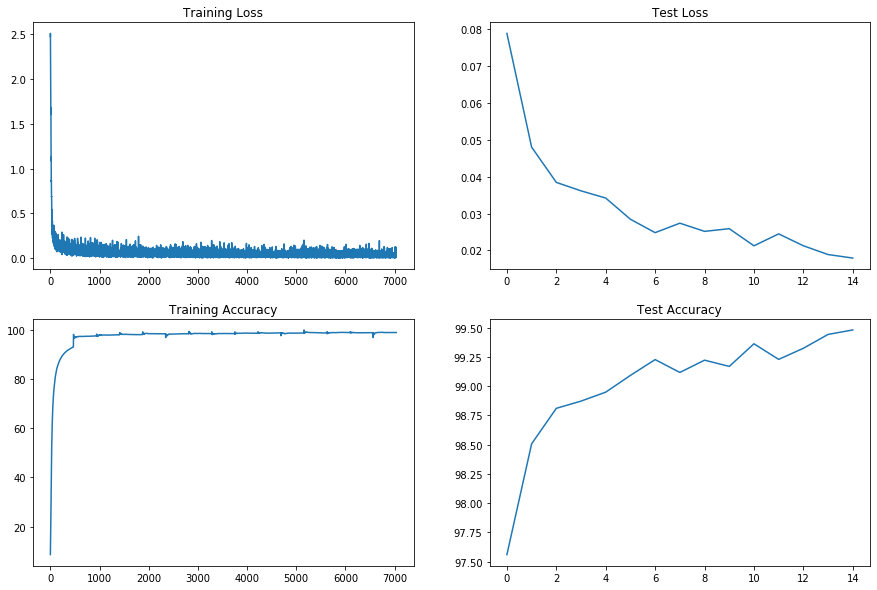

In [0]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [0]:
from torchvision.transforms import ToPILImage
from IPython.display import Image
from PIL import Image

In [66]:
# L1 wrong image predictions
pilTrans = transforms.ToPILImage()

for images in misclassified_list_l1:
  pilImg = pilTrans(images[0].cpu())
  print("Image:")
  display(pilImg)
  print("correct value",images[1])
  print("predicted value",images[2])
  


Image:


correct value 3
predicted value -6.67572021484375e-06
Image:


correct value 7
predicted value -0.00016117095947265625
Image:


correct value 0
predicted value -0.0004253387451171875
Image:


correct value 9
predicted value -0.0005235671997070312
Image:


correct value 9
predicted value -0.0006132125854492188
Image:


correct value 6
predicted value -0.0007266998291015625
Image:


correct value 1
predicted value -0.0007963180541992188
Image:


correct value 9
predicted value -0.0008449554443359375
Image:


correct value 9
predicted value -0.0010509490966796875
Image:


correct value 9
predicted value -0.0013303756713867188
Image:


correct value 9
predicted value -0.0013399124145507812
Image:


correct value 9
predicted value -0.0017032623291015625
Image:


correct value 3
predicted value -0.0017328262329101562
Image:


correct value 4
predicted value -0.0019712448120117188
Image:


correct value 9
predicted value -0.001995086669921875
Image:


correct value 1
predicted value -0.00279998779296875
Image:


correct value 7
predicted value -0.0030384063720703125
Image:


correct value 1
predicted value -0.0033135414123535156
Image:


correct value 9
predicted value -0.0034189224243164062
Image:


correct value 1
predicted value -0.0034852027893066406
Image:


correct value 7
predicted value -0.0041656494140625
Image:


correct value 7
predicted value -0.0043354034423828125
Image:


correct value 4
predicted value -0.00518798828125
Image:


correct value 1
predicted value -0.005330085754394531
Image:


correct value 9
predicted value -0.0056552886962890625


In [68]:
# L2 wrong image predictions
pilTrans = transforms.ToPILImage()

for images in misclassified_list_l2:
  pilImg = pilTrans(images[0].cpu())
  print("Image:")
  display(pilImg)
  print("correct value",images[1])
  print("predicted value",images[2])
  


Image:


correct value 3
predicted value -6.67572021484375e-06
Image:


correct value 7
predicted value -0.00016117095947265625
Image:


correct value 0
predicted value -0.0004253387451171875
Image:


correct value 9
predicted value -0.0005235671997070312
Image:


correct value 9
predicted value -0.0006132125854492188
Image:


correct value 6
predicted value -0.0007266998291015625
Image:


correct value 1
predicted value -0.0007963180541992188
Image:


correct value 9
predicted value -0.0008449554443359375
Image:


correct value 9
predicted value -0.0010509490966796875
Image:


correct value 9
predicted value -0.0013303756713867188
Image:


correct value 9
predicted value -0.0013399124145507812
Image:


correct value 9
predicted value -0.0017032623291015625
Image:


correct value 3
predicted value -0.0017328262329101562
Image:


correct value 4
predicted value -0.0019712448120117188
Image:


correct value 9
predicted value -0.001995086669921875
Image:


correct value 1
predicted value -0.00279998779296875
Image:


correct value 7
predicted value -0.0030384063720703125
Image:


correct value 1
predicted value -0.0033135414123535156
Image:


correct value 9
predicted value -0.0034189224243164062
Image:


correct value 1
predicted value -0.0034852027893066406
Image:


correct value 7
predicted value -0.0041656494140625
Image:


correct value 7
predicted value -0.0043354034423828125
Image:


correct value 4
predicted value -0.00518798828125
Image:


correct value 1
predicted value -0.005330085754394531
Image:


correct value 9
predicted value -0.0056552886962890625
